In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
df = pd.read_csv('sample_submission.csv')
df.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [55]:
df_train = pd.read_csv('train.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [56]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [57]:
missing_cols = df_train.isnull().sum()
print(missing_cols[missing_cols > 0])  # Only print columns with missing values

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [58]:
# Calculate the percentage of missing values for each column
missing_percent = (df_train.isnull().sum() / len(df_train)) * 100

# Identify columns with more than 50% missing values
columns_to_drop = missing_percent[missing_percent > 50].index.tolist()

print("Columns with more than 50% missing values:")
print(columns_to_drop)

Columns with more than 50% missing values:
['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']


In [59]:
# Assuming df is your DataFrame
columns = ['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']
types = df_train[columns].dtypes
print(types)

Alley          object
MasVnrType     object
PoolQC         object
Fence          object
MiscFeature    object
dtype: object


In [60]:
# Assuming df is your DataFrame
df_train = df_train.select_dtypes(exclude=['object'])
# df_train = df_train.drop(columns=['Id'])
df_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [61]:
# Fill missing values in numerical columns with mean
for col in df_train.select_dtypes(include=['float64', 'int64']):
    if col in missing_cols:
        df_train[col].fillna(df_train[col].mean(), inplace=True)
################################################################################
# # Fill missing values in categorical columns with mode
# for col in df_train.select_dtypes(include=['object']):
#     if col in missing_cols:
#         df_train[col].fillna(df_train[col].mode()[0], inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_20900\998511299.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[col].fillna(df_train[col].mean(), inplace=True)


In [62]:
missing_cols = df_train.isnull().sum()
print(missing_cols[missing_cols > 0])  # Only print columns with missing values

Series([], dtype: int64)


In [63]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   OverallQual    1460 non-null   int64  
 5   OverallCond    1460 non-null   int64  
 6   YearBuilt      1460 non-null   int64  
 7   YearRemodAdd   1460 non-null   int64  
 8   MasVnrArea     1460 non-null   float64
 9   BsmtFinSF1     1460 non-null   int64  
 10  BsmtFinSF2     1460 non-null   int64  
 11  BsmtUnfSF      1460 non-null   int64  
 12  TotalBsmtSF    1460 non-null   int64  
 13  1stFlrSF       1460 non-null   int64  
 14  2ndFlrSF       1460 non-null   int64  
 15  LowQualFinSF   1460 non-null   int64  
 16  GrLivArea      1460 non-null   int64  
 17  BsmtFullBath   1460 non-null   int64  
 18  BsmtHalf

In [64]:
# # from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# for col in df_train.select_dtypes(include=['object']):
#     df_train[col] = le.fit_transform(df_train[col])


In [65]:
df_train

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


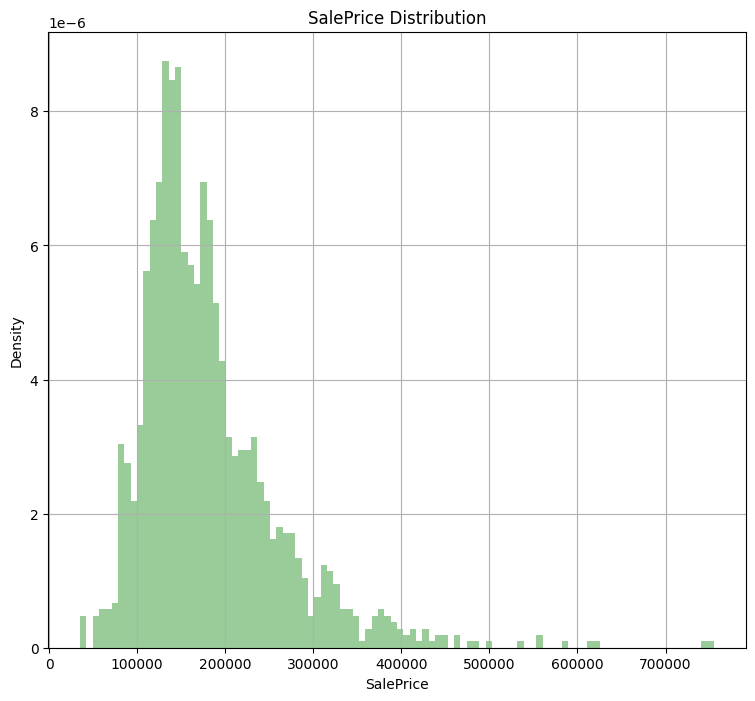

In [66]:
# Describe the SalePrice column
print(df_train['SalePrice'].describe())

# Plotting the distribution
plt.figure(figsize=(9, 8))
plt.hist(df_train['SalePrice'], bins=100, color='g', alpha=0.4, density=True)
plt.title('SalePrice Distribution')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.grid(True)
plt.show()

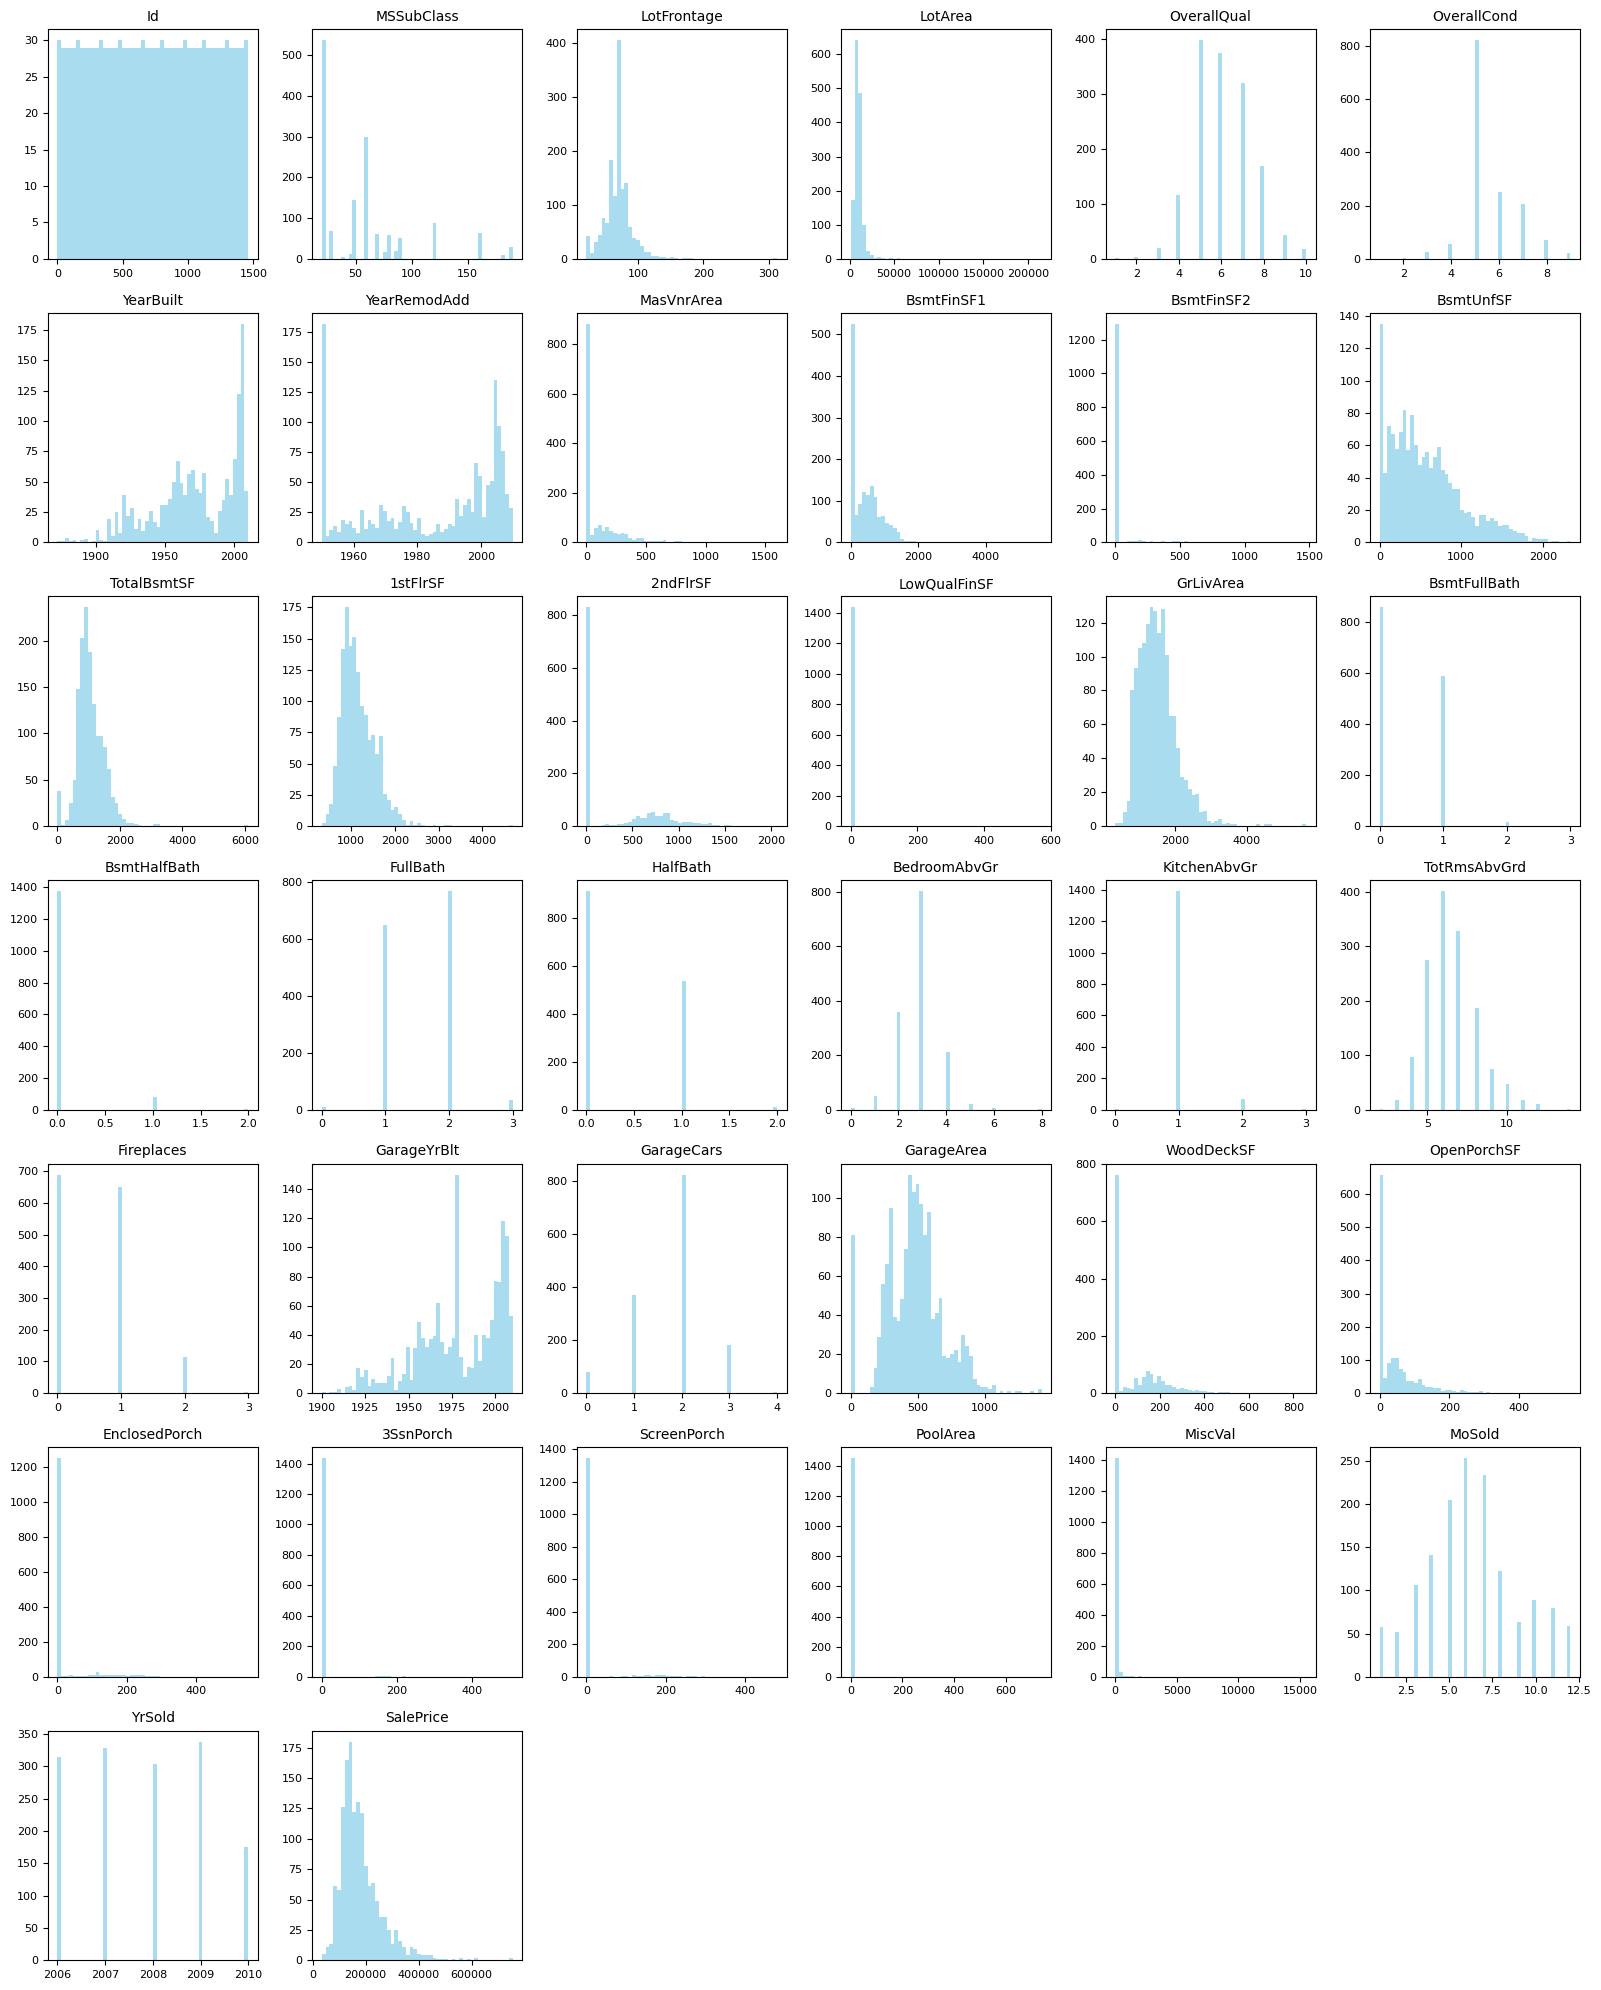

In [67]:
df_train.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8, color='skyblue', alpha=0.7, grid=False)

# Add a title to each subplot for clarity
for ax in plt.gcf().axes:
    ax.set_title(ax.get_title(), fontsize=10)
    ax.set_xlabel(ax.get_xlabel(), fontsize=10)
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)

plt.tight_layout()
plt.show()


In [68]:
df_train.skew().sort_values(ascending=False)

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
MasVnrArea        2.676412
LotFrontage       2.384950
OpenPorchSF       2.364342
SalePrice         1.882876
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
MSSubClass        1.407657
1stFlrSF          1.376757
GrLivArea         1.366560
BsmtUnfSF         0.920268
2ndFlrSF          0.813030
OverallCond       0.693067
TotRmsAbvGrd      0.676341
HalfBath          0.675897
Fireplaces        0.649565
BsmtFullBath      0.596067
OverallQual       0.216944
MoSold            0.212053
BedroomAbvGr      0.211790
GarageArea        0.179981
YrSold            0.096269
FullBath          0.036562
Id                0.000000
GarageCars       -0.342549
YearRemodAdd     -0.503562
YearBuilt        -0.613461
G

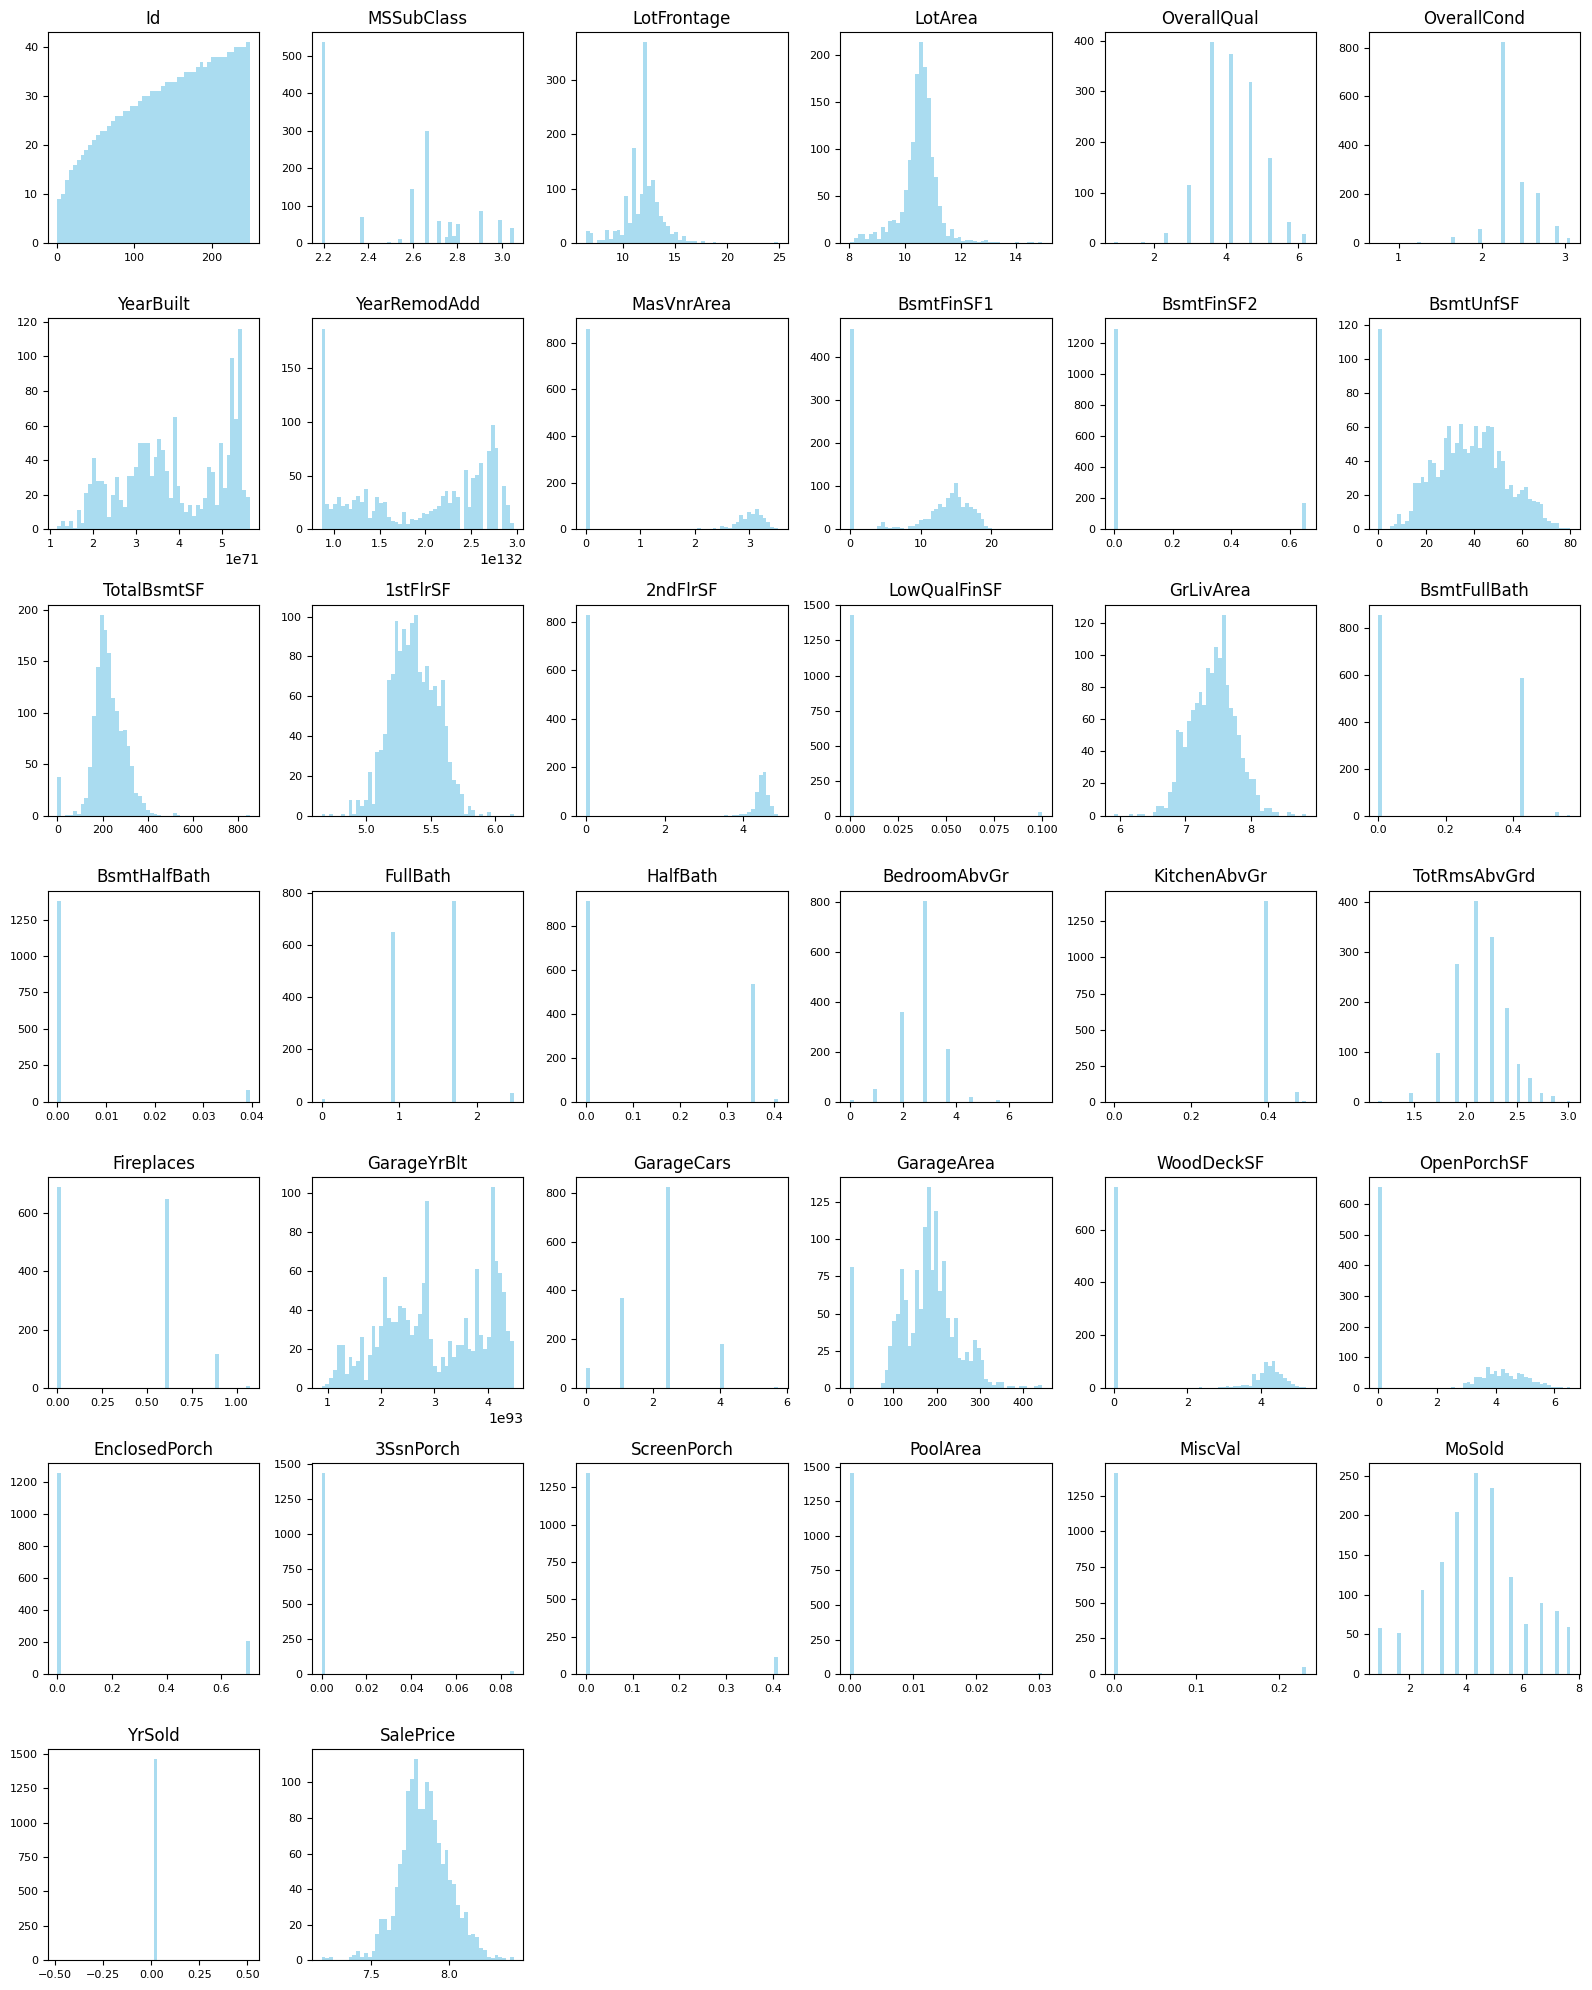

In [69]:
# Apply Box-Cox transformation
df_train_boxcox = df_train.copy()
for col in df_train.columns:
    if np.issubdtype(df_train[col].dtype, np.number):
        # Add a small constant if there are zeros
        df_train_boxcox[col] = boxcox(df_train[col] + 1)[0]

# Plot histograms to check the distribution
df_train_boxcox.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8, color='skyblue', alpha=0.7, grid=False)
plt.tight_layout()
plt.show()


count    1460.000000
mean        7.841927
std         0.158241
min         7.185448
25%         7.744692
50%         7.835410
75%         7.942414
max         8.409777
Name: SalePrice, dtype: float64


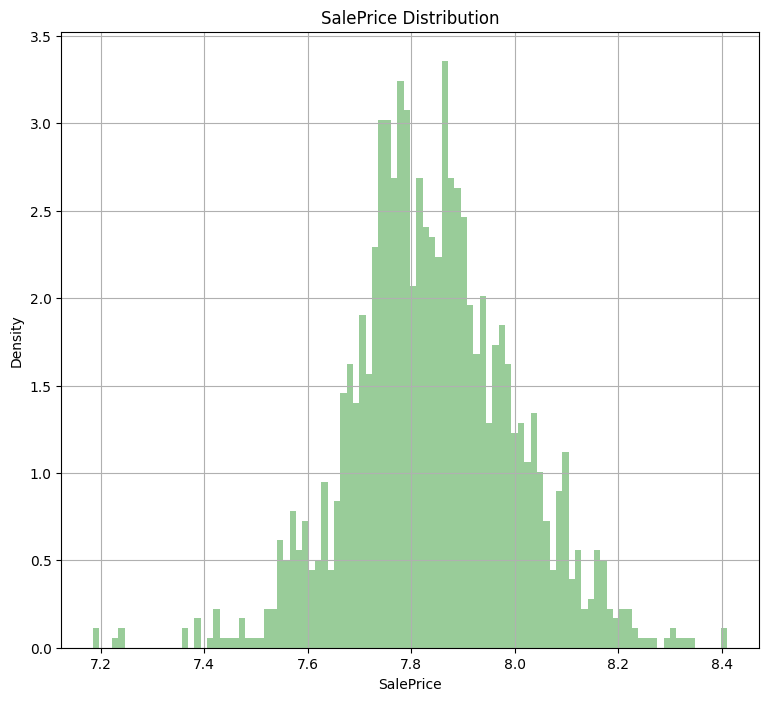

In [70]:
# Describe the SalePrice column
print(df_train_boxcox['SalePrice'].describe())

# Plotting the distribution
plt.figure(figsize=(9, 8))
plt.hist(df_train_boxcox['SalePrice'], bins=100, color='g', alpha=0.4, density=True)
plt.title('SalePrice Distribution')
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.grid(True)
plt.show()

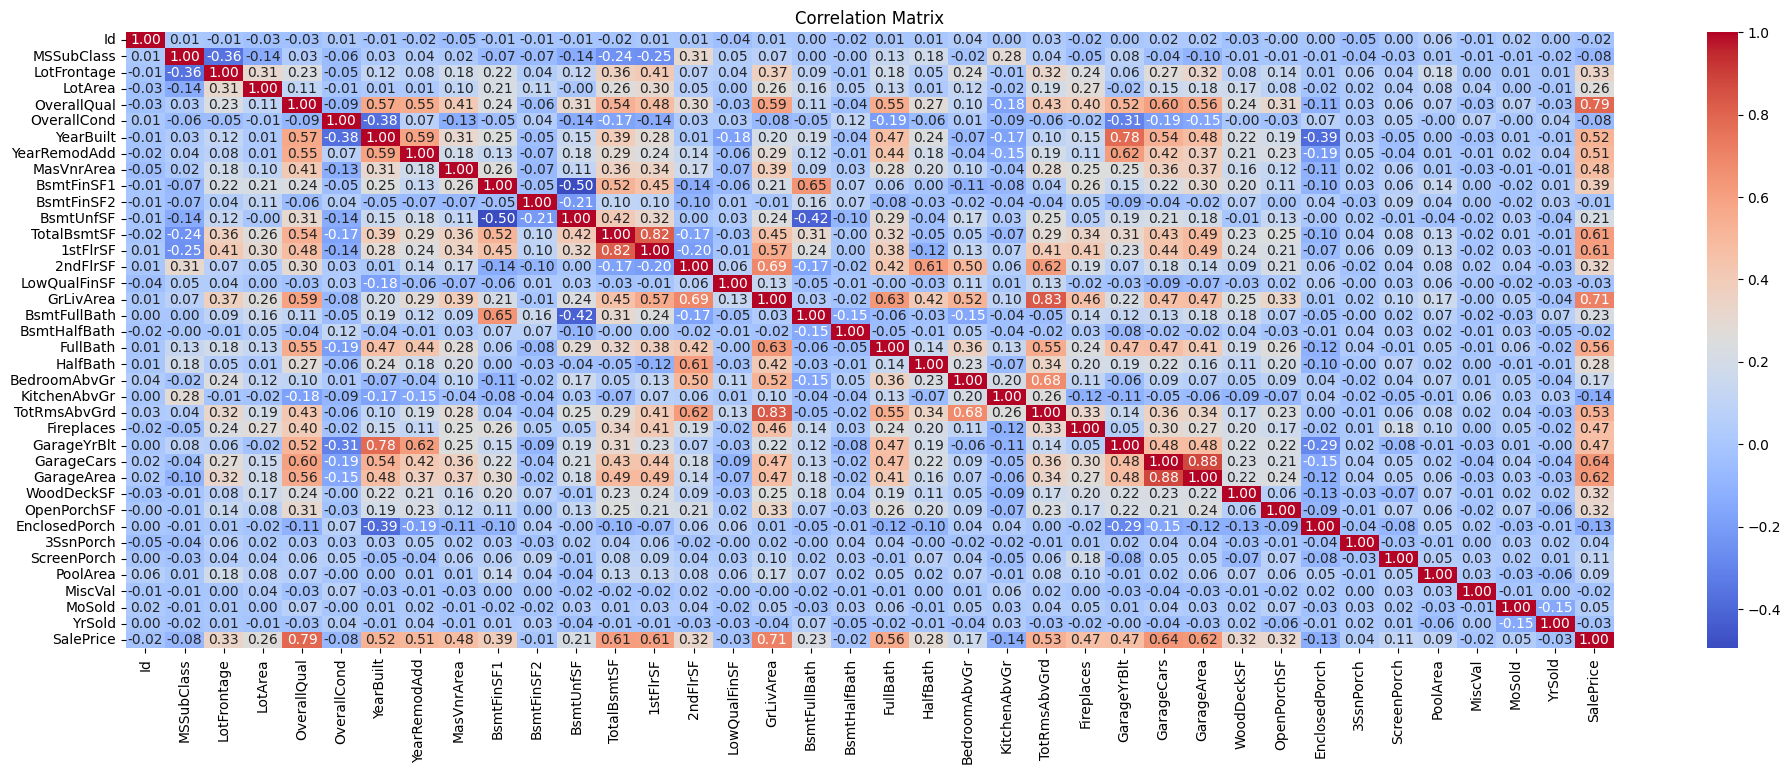

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.475241
GarageYrBlt      0.470177
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.334901
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [71]:
# Compute the correlation matrix for numerical features
corr_matrix = df_train.corr()

# Plotting the heatmap
plt.figure(figsize=(24, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Extract and sort correlation with SalePrice
corr_with_saleprice = corr_matrix['SalePrice'].sort_values(ascending=False)
print(corr_with_saleprice)

In [72]:
# y_train= df_train_boxcox['SalePrice']
# X_train = df_train_boxcox[['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath']]
# df_train_boxcox.head()

<h1> <b> Test set <b/> <h/>


In [73]:
df_test = pd.read_csv('test.csv')
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [74]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [75]:
missing_cols = df_test.isnull().sum()
print(missing_cols[missing_cols > 0])  # Only print columns with missing values

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType       894
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64


In [76]:
# Assuming df is your DataFrame
df_test = df_test.select_dtypes(exclude=['object'])
df_test

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,730.0,140,0,0,0,120,0,0,6,2010
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,312.0,393,36,0,0,0,0,12500,6,2010
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,482.0,212,34,0,0,0,0,0,3,2010
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,470.0,360,36,0,0,0,0,0,6,2010
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,506.0,0,82,0,0,144,0,0,1,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,...,0.0,0,0,0,0,0,0,0,6,2006
1455,2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,...,286.0,0,24,0,0,0,0,0,4,2006
1456,2917,20,160.0,20000,5,7,1960,1996,0.0,1224.0,...,576.0,474,0,0,0,0,0,0,9,2006
1457,2918,85,62.0,10441,5,5,1992,1992,0.0,337.0,...,0.0,80,32,0,0,0,0,700,7,2006


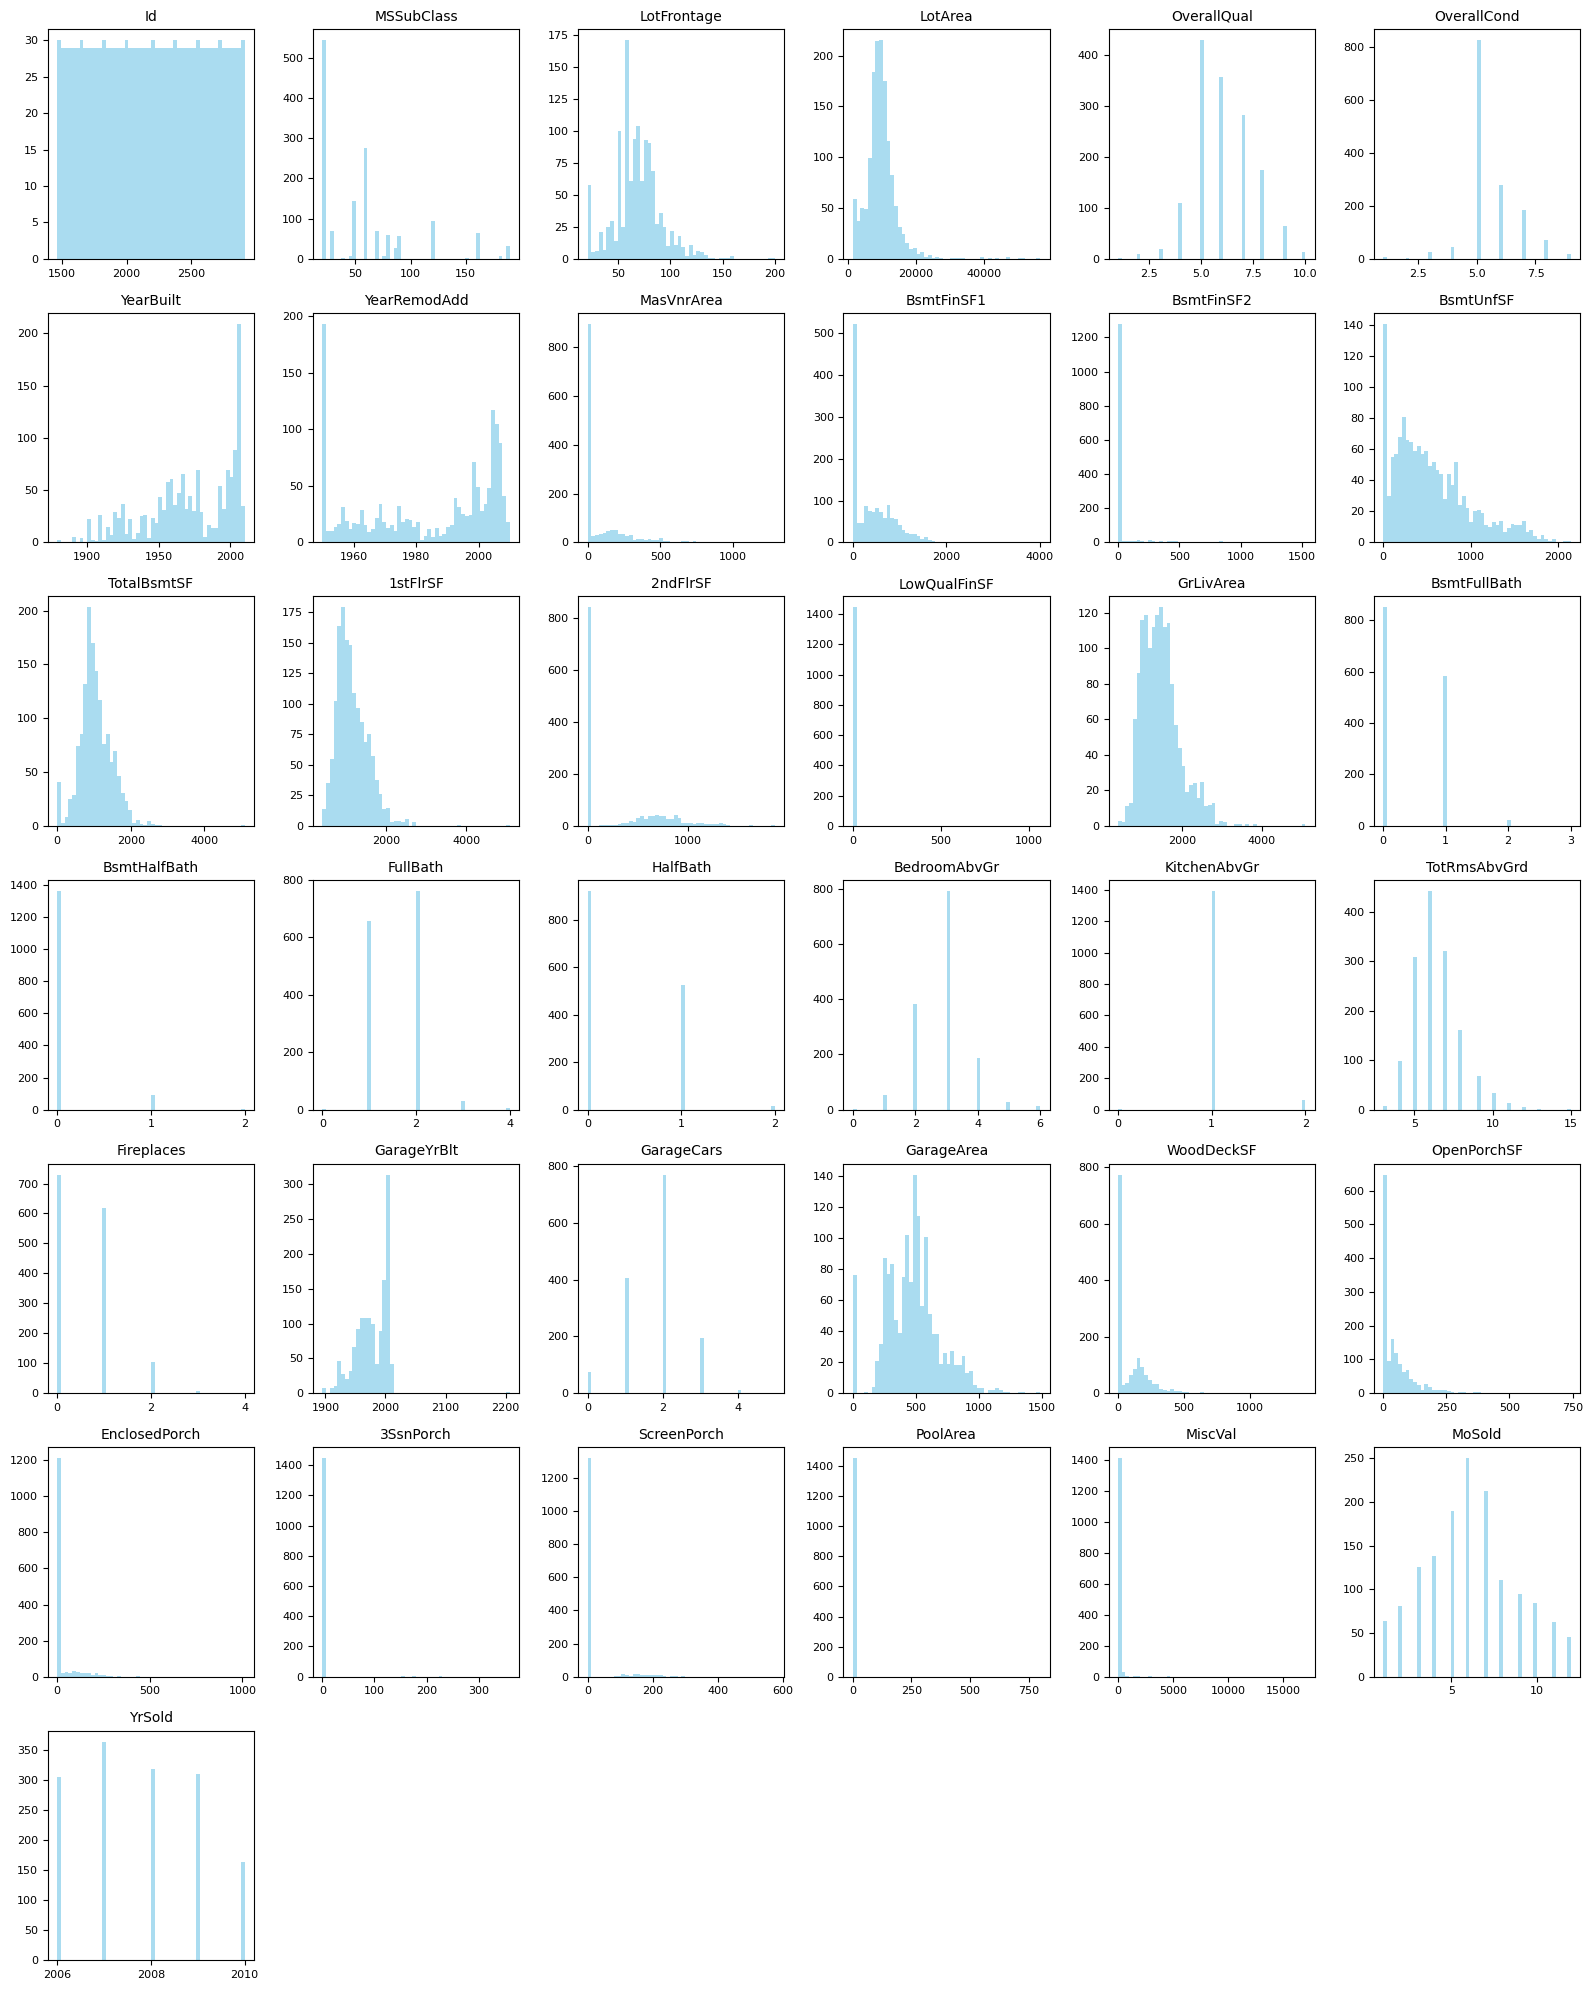

In [77]:
df_test.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8, color='skyblue', alpha=0.7, grid=False)

# Add a title to each subplot for clarity
for ax in plt.gcf().axes:
    ax.set_title(ax.get_title(), fontsize=10)
    ax.set_xlabel(ax.get_xlabel(), fontsize=10)
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)

plt.tight_layout()
plt.show()

In [78]:
# Fill missing values in numerical columns with mean
for col in df_test.select_dtypes(include=['float64', 'int64']):
    if col in missing_cols:
        df_test[col].fillna(df_test[col].mean(), inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_20900\2238580346.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test[col].fillna(df_test[col].mean(), inplace=True)


In [79]:
missing_cols = df_test.isnull().sum()
print(missing_cols[missing_cols > 0])  # Only print columns with missing values

Series([], dtype: int64)


<Figure size 1600x2000 with 0 Axes>

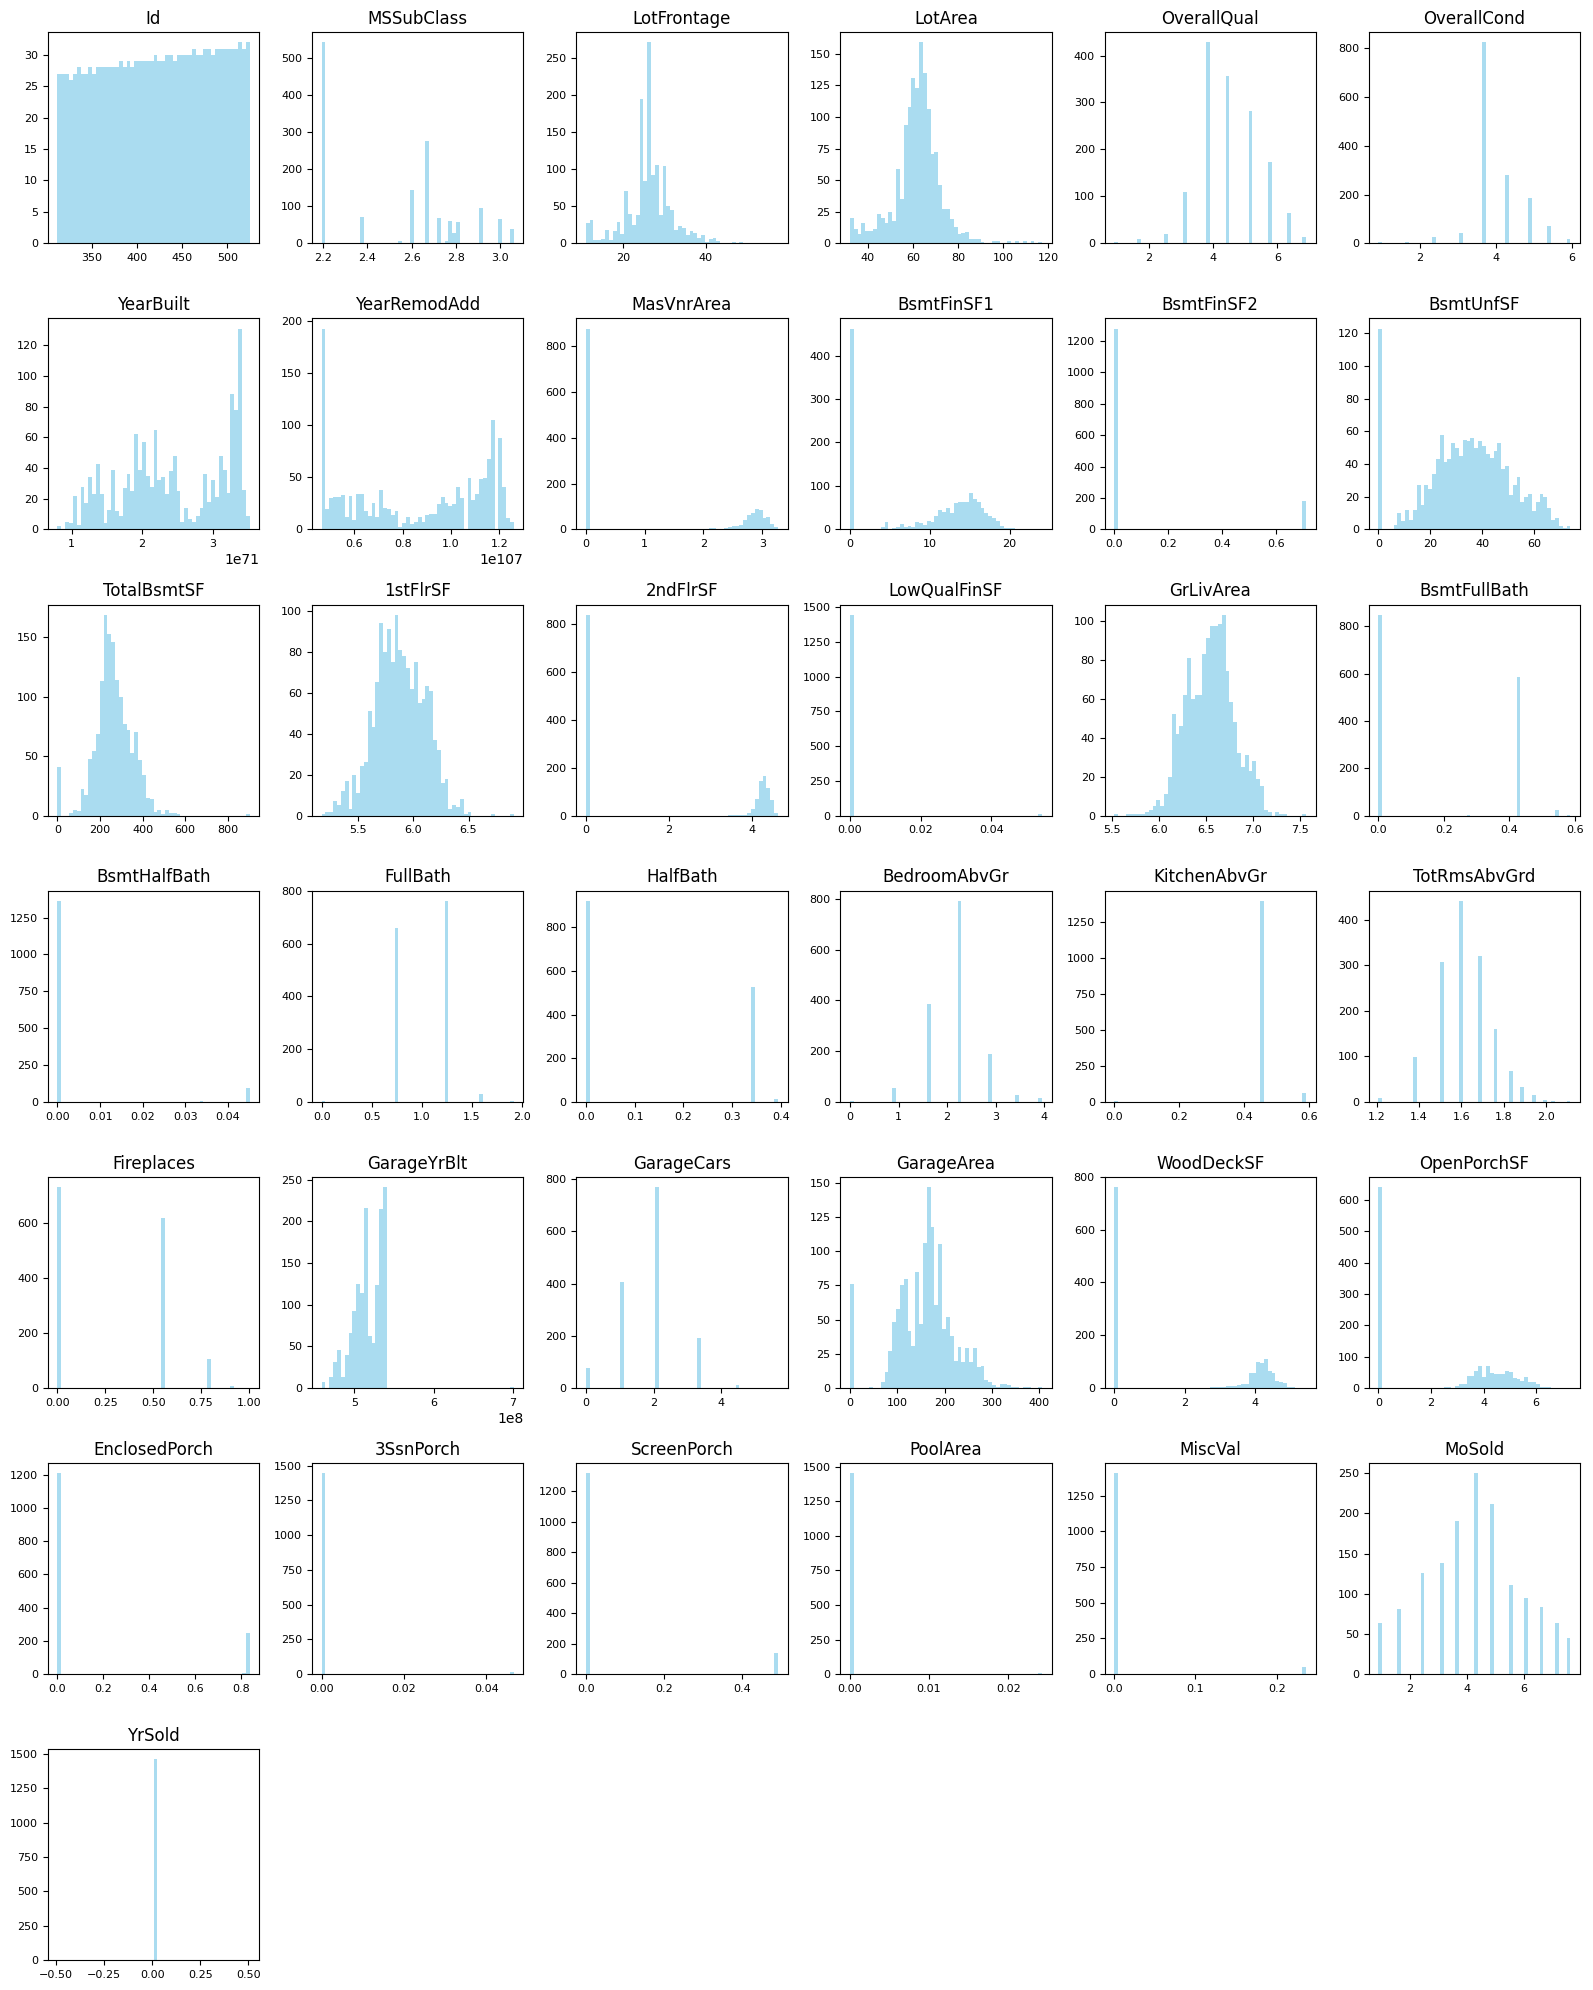

In [80]:
df_test_boxcox = df_test.copy()
for col in df_test_boxcox.columns:
    if np.issubdtype(df_test_boxcox[col].dtype, np.number):
        # Add a small constant if there are zeros
        df_test_boxcox[col] = boxcox(df_test_boxcox[col] + 1)[0]

# Plot histograms for test dataset
plt.figure(figsize=(16, 20))
df_test_boxcox.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8, color='skyblue', alpha=0.7, grid=False)
plt.tight_layout()
plt.show()

In [81]:
# df_test_boxcox = df_test_boxcox[['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath']]
# X_test = df_test_boxcox
# df_test_boxcox.head()

In [82]:
# X_test 

In [83]:
# # Fill missing values in numerical columns with mean
# for col in df_test.select_dtypes(include=['float64', 'int64']):
#     if col in missing_cols:
#         df_test[col].fillna(df_test[col].mean(), inplace=True)
# ################################################################################
# # # Fill missing values in categorical columns with mode
# # for col in df_test.select_dtypes(include=['object']):
# #     if col in missing_cols:
# #         df_test[col].fillna(df_test[col].mode()[0], inplace=True)

In [84]:
# missing_cols = df_test.isnull().sum()
# print(missing_cols[missing_cols > 0])  # Only print columns with missing values

In [85]:
# df_test.info()

<h1> <b>  Separate features and target in train_set <b/> <h1/>

In [86]:
# # Separate features and target in train_set
# X_train = df_train_boxcox.drop(columns=['SalePrice'])
# y_train = df_train['SalePrice']

In [87]:
# X_train

In [88]:
# y_train

In [89]:
# # Features in test_set
# X_test = df_test_boxcox

In [90]:
train_ids = df_train['Id']
test_ids = df_test['Id']

In [91]:
y = df_train_boxcox["SalePrice"]

features = ["OverallQual", "GrLivArea", "GarageCars", "GarageArea", "TotalBsmtSF", "FullBath"]
X = pd.get_dummies(df_train_boxcox[features])
X_test = pd.get_dummies(df_train_boxcox[features])

In [92]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
# X_train = pd.get_dummies(df_train_boxcox[features])
# X_test = pd.get_dummies(df_train_boxcox[features])

In [103]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [104]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [105]:
from sklearn.metrics import mean_squared_error, r2_score
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 0.01
R-squared: 0.83


In [107]:
print(model.score(X_test, y_test))

0.8271418141051451


In [111]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# print(confusion_matrix(y_test, y_pred))
mse = mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)

print('MSE = ',mse)
print('MAE = ',mae)

MSE =  0.005079670950860454
MAE =  0.05019002297808043


In [113]:
#  "OverallQual", "GrLivArea", "GarageCars", "GarageArea", "TotalBsmtSF", "FullBath"
new_df = pd.DataFrame({"OverallQual":[5], "GrLivArea":[1500], "GarageCars":[2], "GarageArea":[500], "TotalBsmtSF":[1000], "FullBath":[2]})
predicted_price = model.predict(new_df)
print(f'Predicted price: {predicted_price[0]}')

Predicted price: 195.5189908808796


In [117]:
ids = {'col1': train_ids , 'col2':test_ids}
df_ids = pd.DataFrame(ids)
output = pd.DataFrame({'Id': df_ids, 'SalePrice': y_pred})

output = output.dropna(subset=['Id'])
output['Id'] = output['Id'].astype(int)


# output.to_csv('submission.csv', index=False) 
print("Your submission was successfully saved!")

base = pd.DataFrame(output)
base

ValueError: Data must be 1-dimensional, got ndarray of shape (1460, 2) instead